<a href="https://colab.research.google.com/github/sahmel/Deep_Learning_Models/blob/master/Sign_MNIST_Conv2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

The data for this model is available at: https://www.kaggle.com/datamunge/sign-language-mnist/home

Sign up and download to find 2 CSV files: sign_mnist_test.csv and sign_mnist_train.csv -- You will upload both of them using this button before you can continue.


In [0]:
uploaded=files.upload()

Saving sign_mnist_test.csv to sign_mnist_test.csv
Saving sign_mnist_train.csv to sign_mnist_train.csv


In [0]:
def get_data(filename):
  # You will need to write code that will read the file passed
  # into this function. The first line contains the column headers
  # so you should ignore it
  # Each successive line contians 785 comma separated values between 0 and 255
  # The first value is the label
  # The rest are the pixel values for that picture
  # The function will return 2 np.array types. One with all the labels
  # One with all the images
  #
  # Tips: 
  # If you read a full line (as 'row') then row[0] has the label
  # and row[1:785] has the 784 pixel values
  # Take a look at np.array_split to turn the 784 pixels into 28x28
  # You are reading in strings, but need the values to be floats
  # Check out np.array().astype for a conversion
    with open(filename) as training_file:
        reader = csv.reader(training_file, delimiter=',')    
        imgs = []
        labels = []

        next(reader, None)
        
        for row in reader:
            label = row[0]
            data = row[1:]
            img = np.array(data).reshape((28, 28))

            imgs.append(img)
            labels.append(label)

        images = np.array(imgs).astype(float)
        labels = np.array(labels).astype(float)
            
    return images, labels

training_images, training_labels = get_data('sign_mnist_train.csv')
testing_images, testing_labels = get_data('sign_mnist_test.csv')

# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

# Output should be:
# (27455, 28, 28)
# (27455,)
# (7172, 28, 28)
# (7172,)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [0]:
training_images = np.expand_dims(training_images, axis=3)
testing_images = np.expand_dims(testing_images, axis=3)


# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255.)
    
print(training_images.shape)
print(testing_images.shape)
    
# Output should be:
# (27455, 28, 28, 1)
# (7172, 28, 28, 1)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [0]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(26, activation='softmax')]
    )

# Compile Model. 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

# Configure generators
training_generator = train_datagen.flow(training_images, training_labels, batch_size=64)
validation_generator = validation_datagen.flow(testing_images, testing_labels, batch_size=64)

# Train the Model
history = model.fit_generator(training_generator, validation_data=validation_generator, epochs=100, 
                              verbose=1, callbacks=[callbacks])

model.evaluate(testing_images, testing_labels, verbose=0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 1, 128)         73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)              

[393.9618225097656, 0.6692693829536438]

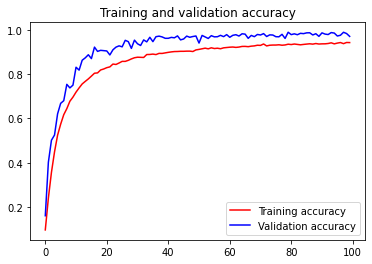

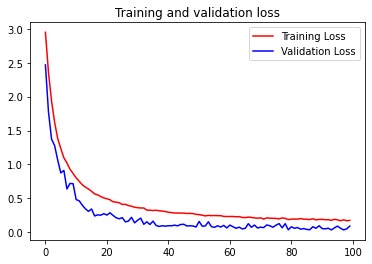

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()